In [138]:
import os
import pickle
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import namedtuple
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.manifold import TSNE

In [139]:
res_dir = "./tmp_result"
results_paths = [each for each in os.listdir(res_dir) if "results" in each]
results = []
Result = namedtuple("result", "words label attribution")
for path in results_paths:
    with open(os.path.join(res_dir, path), "rb") as f:
        res = pickle.load(f)
        results.append(Result(**res))

In [140]:
with open("results-roberta.jl","wb") as f:
    joblib.dump([tuple(result) for result in results], f)

In [78]:
sent = []
for idx, result in enumerate(results):
    sent.append(" ".join(result.words))

In [79]:
def tokenizer(text):
    return text.split(" ")
cv = CountVectorizer(ngram_range=(1,3),  binary=True, tokenizer=tokenizer, max_features=30000)
cv_fit=cv.fit_transform(sent)
vocab_ngram = cv.get_feature_names()
ngram = cv_fit.todense()
vocab_wtoi = {w:i for i,w in enumerate(vocab_ngram)}

In [80]:
vocab_size = len(vocab_ngram)
sample_size = len(results)
label = np.zeros((sample_size, 1))
attmatrix = np.zeros((sample_size, vocab_size))
for idx, result in enumerate(results):
    label[idx] = result.label
    ngs = [vocab_ngram[idx] for idx in np.where(ngram[idx] == 1)[1]]
    for ng in ngs:
        words = ng.split(" ")
        at = 0
        for word in words:
            try:
                at += result.attribution[result.words.index(word)]
            except ValueError:
                print(result.words, word, ng)
        #at /= len(words)
        attmatrix[idx, vocab_wtoi[ng]] = at

In [81]:
print(attmatrix.shape)
print(label.shape)
len(vocab_ngram)

(5094, 30000)
(5094, 1)


30000

In [82]:
np.save("attmatrix-roberta-sum.npy", attmatrix)
np.save("label-roberta-sum.npy", label)
with open("vocab_ngram-roberta-sum.pkl","wb") as f:
    pickle.dump(vocab_ngram, f)

In [83]:
attmatrix = np.load("attmatrix-roberta-sum.npy")
label = np.load("label-roberta-sum.npy")
with open("vocab_ngram-roberta-sum.pkl","rb") as f:
    vocab_ngram = pickle.load(f)

In [84]:
atts = []
labels = []
for i in range(3):
    atts.append(attmatrix[label.ravel()==i, :])
    labels.append(np.array([i]*np.sum(label.ravel()==i)))
attmatrix = np.concatenate(atts)
label = np.concatenate(labels)

In [103]:
std_idxs = attmatrix.var(axis=0).argsort()[::-1][:500]
attm_with_vars = attmatrix[:, std_idxs]

In [104]:
attm_with_vars.shape

(5094, 500)

In [105]:
def correct_pvalues_for_multiple_testing(pvalues, correction_type = "Benjamini-Hochberg"):                
    from numpy import array, empty                                                                        
    pvalues = array(pvalues) 
    n = pvalues.shape[0]                                                                           
    new_pvalues = empty(n)
    if correction_type == "Bonferroni":                                                                   
        new_pvalues = n * pvalues
    elif correction_type == "Bonferroni-Holm":                                                            
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        for rank, vals in enumerate(values):                                                              
            pvalue, i = vals
            new_pvalues[i] = (n-rank) * pvalue                                                            
    elif correction_type == "Benjamini-Hochberg":                                                         
        values = [ (pvalue, i) for i, pvalue in enumerate(pvalues) ]                                      
        values.sort()
        values.reverse()                                                                                  
        new_values = []
        for i, vals in enumerate(values):                                                                 
            rank = n - i
            pvalue, index = vals                                                                          
            new_values.append((n/rank) * pvalue)                                                          
        for i in range(0, int(n)-1):  
            if new_values[i] < new_values[i+1]:                                                           
                new_values[i+1] = new_values[i]                                                           
        for i, vals in enumerate(values):
            pvalue, index = vals
            new_pvalues[index] = new_values[i]                                                                                                                  
    return new_pvalues

In [129]:
res = []
for cls in range(3):
    mean_cls = attm_with_vars[label==cls].mean(axis=0)
    mean_ncls = attm_with_vars[label!=cls].mean(axis=0)
    sep = mean_cls-mean_ncls
    pvalue = []
    for i in range(attm_with_vars.shape[1]):
        data1 = attm_with_vars[label==cls, i]
        data2 = attm_with_vars[label!=cls, i]
        ttest = stats.ttest_ind(data1, data2, equal_var=False)
        pvalue.append(ttest[1])
    pvalue = np.array(pvalue)
    pvalue = correct_pvalues_for_multiple_testing(pvalue)
    result = pd.DataFrame({"idx":list(range(sep.shape[0])),"sep":sep,"pvalue":pvalue})
    result['sig'] = 'normal'
    result.loc[(result.sep > 0 )&(result.pvalue < 1e-7),'sig'] = 'up'
    posresult = result[result["sig"] == 'up'].sort_values("sep",ascending=False)
    res.append(list(posresult["idx"].iloc[0:30]))

In [130]:
def filter_result(result):
    import re
    from zhon.hanzi import punctuation
    clean_res = []
    keys = []
    for res in result:
        res_wo_punc = re.sub(r"[%s]" % punctuation, "", res)
        res_wo_punc = res_wo_punc.replace("  ", " ").strip()
        if res_wo_punc not in clean_res:
            clean_res.append(res_wo_punc)
            if res_wo_punc in result:
                keys.append(res_wo_punc)
            else:
                keys.append(res)
    return clean_res, keys

In [131]:
select_idx = []
features = {}
for l, each in enumerate(res):
    feat = {vocab_ngram[std_idxs[idx]]:std_idxs[idx] for idx in each}
    clean_feat, keys = filter_result(list(feat.keys()))
    features[l] = clean_feat
    select_idx += [feat[each] for each in keys]
select_idx = list(set(select_idx))

In [132]:
with open("features-roberta.pkl", "wb") as f:
    pickle.dump(features, f)

In [133]:
attm_with_ttest = attmatrix[:, select_idx]
print(len(select_idx))

45


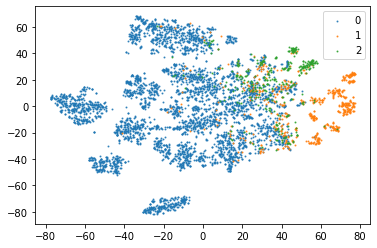

In [134]:
pca = TSNE(n_components=2)
attmatrix_pca = pca.fit_transform(attm_with_ttest)
for i in range(3):
        plt.scatter(attmatrix_pca[label==i,0], attmatrix_pca[label==i,1], alpha=0.8, label='%s' % i, s=1)
plt.legend()
plt.show()

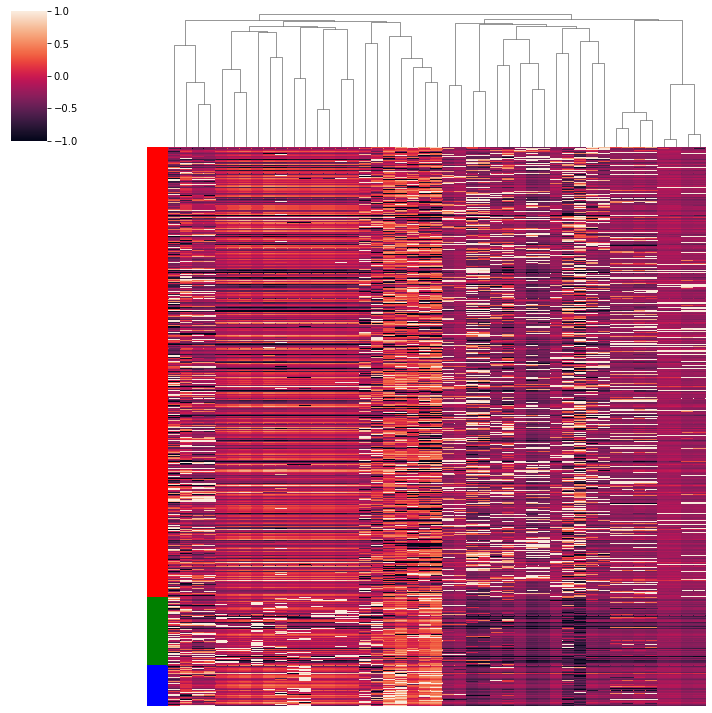

In [137]:
pattm = attm_with_ttest
for i in range(pattm.shape[0]):
    pattm[i, :] = pattm[i, :] - pattm[i, :].mean()
for i in range(pattm.shape[1]):
    pattm[:, i] = (pattm[:, i] - pattm[:, i].mean())/pattm[:, i].std()
cm = sns.clustermap(pattm,vmin=-1, vmax=1, row_cluster=False, 
               row_colors=["rgb"[l] for l in label], 
               xticklabels=False,
               yticklabels=False,)